In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from sklearn.decomposition import TruncatedSVD

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [5]:
!cd /content/drive/MyDrive/

In [ ]:
!kaggle datasets download -d surajjha101/bigbasket-entire-product-list-28k-datapoints

  0% 0.00/6.04M [00:00<?, ?B/s]
100% 6.04M/6.04M [00:00<00:00, 87.7MB/s]


In [6]:
!kaggle datasets download -d skillsmuggler/amazon-ratings

 59% 17.0M/28.8M [00:00<00:00, 55.7MB/s]
100% 28.8M/28.8M [00:00<00:00, 75.6MB/s]


In [7]:
!mkdir dataset

In [ ]:
!unzip bigbasket-entire-product-list-28k-datapoints.zip -d dataset

Archive:  bigbasket-entire-product-list-28k-datapoints.zip
  inflating: dataset/BigBasket Products.csv  


In [8]:
!unzip amazon-ratings.zip -d dataset

Archive:  amazon-ratings.zip
  inflating: dataset/ratings_Beauty.csv  


In [9]:
df_amazon = pd.read_csv('/content/dataset/ratings_Beauty.csv')

In [ ]:
df_bigbasket = pd.read_csv('/content/dataset/BigBasket Products.csv')

In [ ]:
df_amazon.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
df_bigbasket.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [ ]:
df_amazon.shape

(2023070, 4)

In [ ]:
df_bigbasket.shape

(27555, 10)

## Amazon Beauty Products

### EDA

In [ ]:
df_amazon.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [ ]:
popular_products = pd.DataFrame(df_amazon.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<Axes: xlabel='ProductId'>

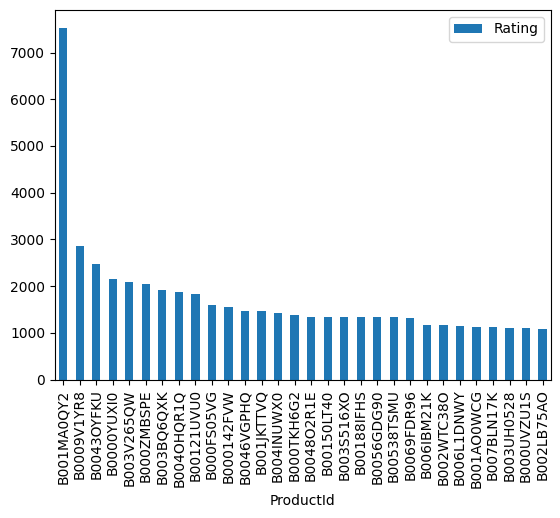

In [ ]:
most_popular.head(30).plot(kind = "bar")

### Recommendation by Collaborative Filtering

It relies on user behavior data to identify patterns and make recommendations based on similar user preferences.

I use this dataset for collaborative filtering because this technique use the purches history of customer.

Let's create a user-item matrix from the dataset. This matrix represents the user-item interactions.

In [10]:
# Subset of Amazon Ratings cause it itself is too large
df_amazon1 = df_amazon.head(10000)

In [11]:
user_item_matrix = df_amazon1.pivot_table(
    index='UserId', columns='ProductId', values='Rating', fill_value=0)

Singular Value Decomposition (SVD) that helps to reduce the dimensionality of a matrix.

In [12]:
X = user_item_matrix.T
X1 = X

SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)

In [13]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix

array([[ 1.        , -0.96610216, -0.97906153, ..., -0.26111475,
         0.1577711 ,  0.04073659],
       [-0.96610216,  1.        ,  0.92149301, ...,  0.23949487,
        -0.24342233, -0.12577224],
       [-0.97906153,  0.92149301,  1.        , ...,  0.25985312,
        -0.22339913, -0.06477209],
       ...,
       [-0.26111475,  0.23949487,  0.25985312, ...,  1.        ,
        -0.05902707, -0.06897313],
       [ 0.1577711 , -0.24342233, -0.22339913, ..., -0.05902707,
         1.        ,  0.86888819],
       [ 0.04073659, -0.12577224, -0.06477209, ..., -0.06897313,
         0.86888819,  1.        ]])

Let's pick a random product.

In [14]:
X.index[99]

'6117036094'

In [15]:
i = "6117036094"

product_names = list(X.index)
product_ID = product_names.index(i)

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product.

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)


Recommending top 10 highly correlated products in sequence:


In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i)

result = Recommend[0:10]
result

['0737104473',
 '1304146537',
 '1304168522',
 '1304482596',
 '1304488608',
 '1304495396',
 '130451112X',
 '1304622428',
 '1304622622',
 '1304651347']

## BigBasket

### Cleaning and EDA

In [ ]:
df_bigbasket = df_bigbasket.drop(columns=['index'])
df_bigbasket.head()

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


In [ ]:
df_bigbasket.isnull().sum()

product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

In [ ]:
print('Percentage Null Data In Each Column')
print('-'*30)
for col in df_bigbasket.columns:
    null_count = df_bigbasket[col].isnull().sum()
    total_count = df_bigbasket.shape[0]
    print("{} : {:.2f}".format(col,null_count/total_count * 100))

Percentage Null Data In Each Column
------------------------------
product : 0.00
category : 0.00
sub_category : 0.00
brand : 0.00
sale_price : 0.00
market_price : 0.00
type : 0.00
rating : 31.30
description : 0.42


In [ ]:
print('Total Null Data')
null_count = df_bigbasket.isnull().sum().sum()
total_count = np.product(df_bigbasket.shape)
print("{:.2f}".format(null_count/total_count * 100))

Total Null Data
3.53


So overall 3% data is missing but 31% of ratings are missing. Since we are going to create a recommender system, let's drop the null values as there will still be over 69% data for recommendation purposes which is enough for us.

In [ ]:
df_bigbasket = df_bigbasket.dropna()

In [ ]:
df_bigbasket = df_bigbasket.drop_duplicates()

In [ ]:
df_bigbasket.shape

(18650, 9)

In [ ]:
df_bigbasket.head(20)

,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.00,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.00,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.00,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.00,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.00,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...
5,Germ - Removal Multipurpose Wipes,Cleaning & Household,All Purpose Cleaners,Nature Protect,169.00,199.0,Disinfectant Spray & Cleaners,3.3,Stay protected from contamination with Multipu...
6,Multani Mati,Beauty & Hygiene,Skin Care,Satinance,58.00,58.0,Face Care,3.6,Satinance multani matti is an excellent skin t...
7,Hand Sanitizer - 70% Alcohol Base,Beauty & Hygiene,Bath & Hand Wash,Bionova,250.00,250.0,Hand Wash & Sanitizers,4.0,70%Alcohol based is gentle of hand leaves skin...
8,Biotin & Collagen Volumizing Hair Shampoo + Bi...,Beauty & Hygiene,Hair Care,StBotanica,1098.00,1098.0,Shampoo & Conditioner,3.5,"An exclusive blend with Vitamin B7 Biotin, Hyd..."
9,"Scrub Pad - Anti- Bacterial, Regular",Cleaning & Household,"Mops, Brushes & Scrubs",Scotch brite,20.00,20.0,"Utensil Scrub-Pad, Glove",4.3,Scotch Brite Anti- Bacterial Scrub Pad thoroug...


In [ ]:
counts = df_bigbasket['category'].value_counts()
counts_df = pd.DataFrame({'Category':counts.index,'Counts':counts.values})

In [ ]:
px.bar(data_frame=counts_df,
 x='Category',
 y='Counts',
 color='Counts',
 color_continuous_scale='greens',
 text_auto=True,
 title=f'Count of Items in Each Category')

In [ ]:
counts = df_bigbasket['product'].value_counts()
counts_df_product = pd.DataFrame({'Product':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_product,
 x='Product',
 y='Counts',
 color='Counts',
 color_continuous_scale='greens',
 text_auto=True,
 title=f'Top 10 Sold Products')

In [ ]:
counts = df_bigbasket['sub_category'].value_counts()
counts_df_1 = pd.DataFrame({'Category':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_1,
 x='Category',
 y='Counts',
 color='Counts',
 color_continuous_scale='greens',
 text_auto=True,
 title=f'Top 10 Sold Sub_Categories')

In [ ]:
counts = df_bigbasket['brand'].value_counts()
counts_df_brand = pd.DataFrame({'Brand Name':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_brand,
 x='Brand Name',
 y='Counts',
 color='Counts',
 color_continuous_scale='greens',
 text_auto=True,
 title=f'Top 10 Brand Items based on Item Counts')

In [ ]:
counts = df_bigbasket['type'].value_counts()
counts_df_type = pd.DataFrame({'Type':counts.index,'Counts':counts.values})[:10]

In [ ]:
px.bar(data_frame=counts_df_type,
 x='Type',
 y='Counts',
 color='Counts',
 color_continuous_scale='greens',
 text_auto=True,
 title=f'Top 10 Types of Products based on Item Counts')


**Effect of discounted prices**

In [ ]:
df_bigbasket['diff_in_prices'] = df_bigbasket['market_price'] - df_bigbasket['sale_price']
discount = df_bigbasket[df_bigbasket['diff_in_prices'] != 0]

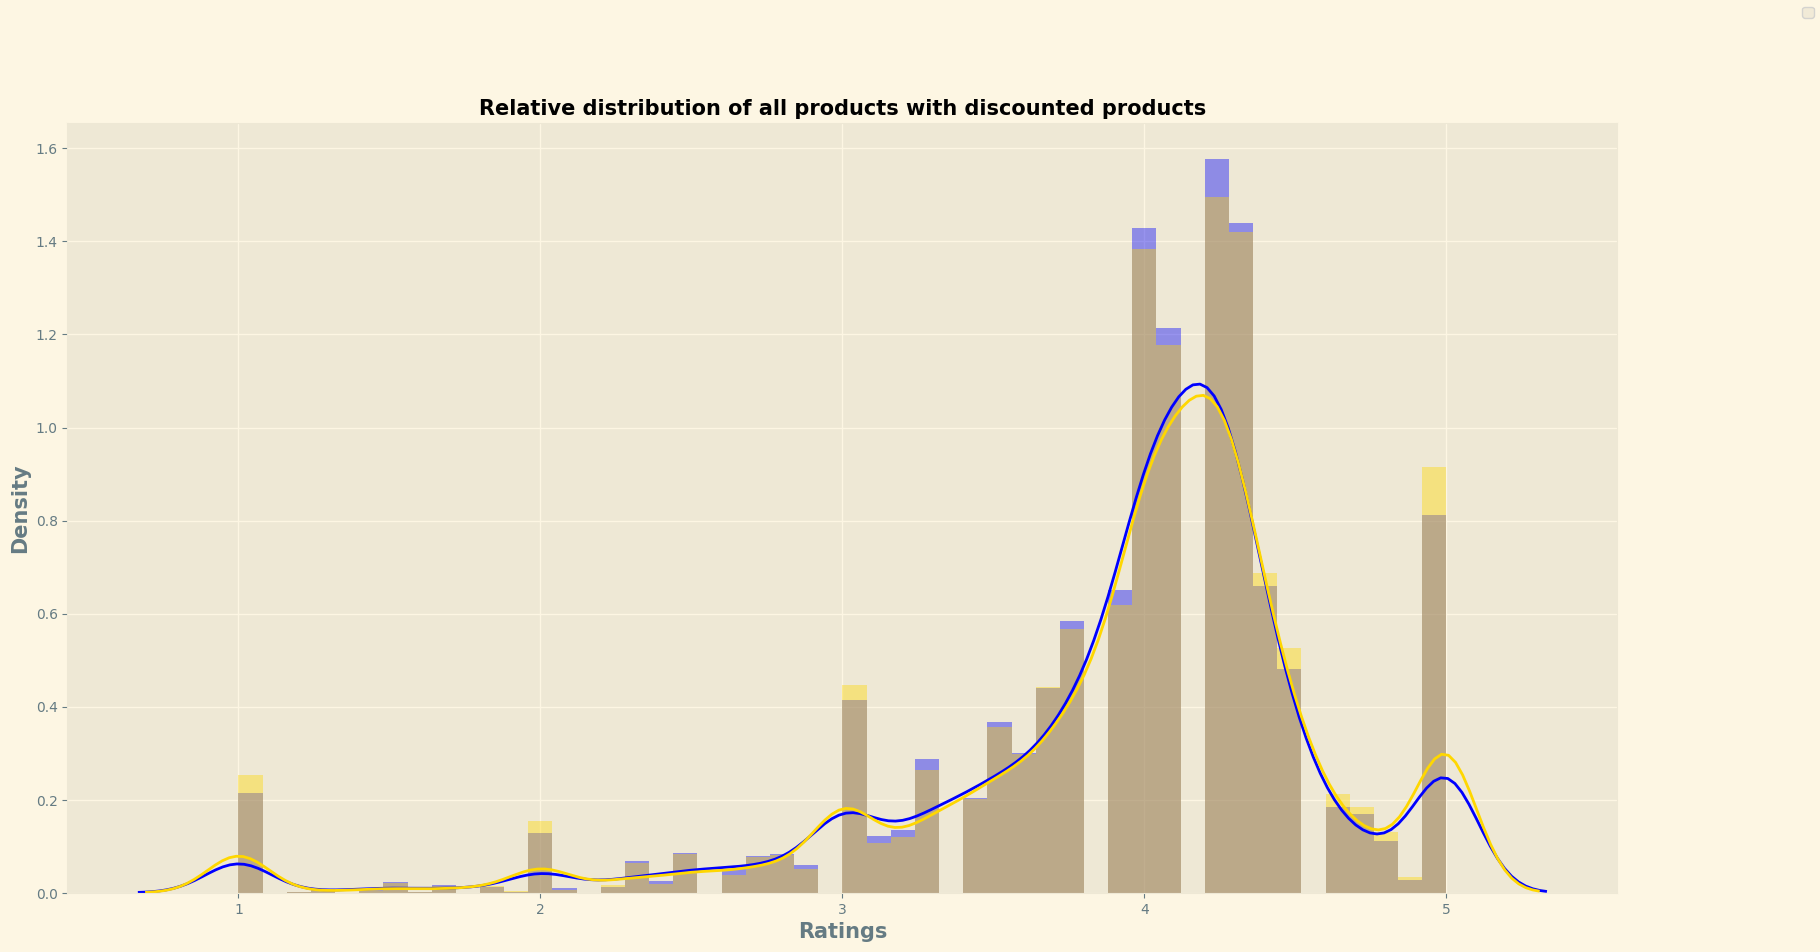

In [ ]:
fig = plt.figure(figsize=(20,10))

plt.style.use("Solarize_Light2")
sns.distplot(discount['rating'], color='b', kde =True)
sns.distplot(df_bigbasket['rating'], color='gold', kde =True)
plt.xlabel("Ratings",fontsize=15, weight='semibold')
plt.ylabel("Density",fontsize=15, weight='semibold')
plt.title("Relative distribution of all products with discounted products",fontsize=15, weight='semibold')
fig.legend()

In the above graph, yellow color specifies rating of all the items, whereas blue color denotes the ratings of the items on which some discount has been offered. As we see,

>the offered discounts showed a little increase in purchase of items with 3.0 to 4.2 ratings. Otherwise, discounts helped no increase in purchase. Another interesting observation was that the highest rated products (4.5 to 5) with no discount exceeded the rate of purchase of discounted products. It means the customers if provided with high quality products which satisfy them, will buy the products no matter discount is offered or not.

### Recommendation By Content-based Filtering

Content-based filtering uses the characteristics or details of items that the user has searched for to suggest similar items.

Let's try using other features such as Description for much better Recommendation.

We will be using NLP here to extract useful info from the features especially Description.

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
des_tfidf_matrix = tfidf.fit_transform(df_bigbasket['description'])
des_tfidf_matrix.shape

(18650, 23342)

Now to compute the similarity score, let's use Linear_Kernel.
Linear Kernel which Calculates the Dot Product of the tfidf_matrix and returns an aggreate value depicting the Similarity score.

In [ ]:
des_cosine_sim = linear_kernel(des_tfidf_matrix, des_tfidf_matrix)
des_cosine_sim

array([[1.        , 0.016307  , 0.01003499, ..., 0.01060276, 0.01131929,
        0.        ],
       [0.016307  , 1.        , 0.00720632, ..., 0.        , 0.        ,
        0.        ],
       [0.01003499, 0.00720632, 1.        , ..., 0.0063872 , 0.        ,
        0.        ],
       ...,
       [0.01060276, 0.        , 0.0063872 , ..., 1.        , 0.        ,
        0.        ],
       [0.01131929, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
def get_recommendations(product):

    # get all product titles
    product_titles = df_bigbasket['product'].values

    # check if the product is recognized
    if product not in product_titles:
        return 'Product Not Recognized.'

    similarities = des_cosine_sim
    # get the index number of product
    index_of_product= np.where(product_titles == product)[0]

    # get similarity of all products to input product
    similarity_scores= similarities[index_of_product].ravel()

    # make a dictionary of {title: similarity_score, title: similarity_score, ...}
    titles_and_scores= dict(zip(product_titles, similarity_scores))

    # sort dictionary by score
    # get top 10 products
    top_10_most_similar= sorted(titles_and_scores.items(), key= lambda x: x[1], reverse= True)[1:11]

    titles = []
    ratings = []
    for i, (name, score) in enumerate(top_10_most_similar):
      titles.append(name)
      rating = df_bigbasket.loc[df_bigbasket['product'] == name, 'rating'].iloc[0]
      ratings.append(rating)

    data = {
        'Title': titles,
        'Rating': ratings
    }

    df = pd.DataFrame(data)

    return df

In [ ]:
get_recommendations('Cadbury Perk - Chocolate Bar')

,Title,Rating
0,Cadbury Perk - Chocolate Bar,4.2
1,Choco Stick - Hexagon Pack,4.4
2,Luvit Chocwich White Home Delights 187 g,4.1
3,Luvit Chocwich Home Delights 187 g,3.9
4,Wafer Biscuits - Chocolate Flavor,4.2
5,Drinking Chocolate - Original,4.0
6,Biscuit - Bourbon Creams,4.1
7,Wafers With Hazelnut Cream,5.0
8,Choco Stick - Chocolate,4.5
9,Smackers Lollipop - Fruit Flavoured,4.4


In [ ]:
get_recommendations('Dove Plastic Soap Case - Assorted Colour')

,Title,Rating
0,Maharaja Plastic Soap Case - Lily Garden Brown,4.1
1,Dove Designer 2 In One Soap Case - Assorted Co...,3.7
2,Pixel Printed Designer Tub - Assorted Colour,4.5
3,Lemon & Tea Tree Oil Soap,4.2
4,"Bathroom Set - Assorted Colour, Premium",5.0
5,Cooling Mint Soap,4.2
6,"Marvel Plastic Bathroom Patla & Stool - Plain,...",3.8
7,"Dyna Plastic Bathroom Stool/Patla - Plain, Ass...",2.9
8,"Dyna Plastic Bathroom Stool/Patla - Printed, A...",2.2
9,Soap Bar - Lemon & Tea Tree Oil,4.3
